# Flow Matching: Practical Session

**Master 2 - Advanced Deep Learning**

This notebook provides a comprehensive introduction to Flow Matching techniques, covering both continuous and discrete flow matching. We'll start with intuitive 1D examples and then move to practical 2D implementations.

## Learning Objectives

By the end of this session, you should be able to:
- Understand the core concepts of Flow Matching
- Implement continuous flow matching models
- Implement discrete flow matching models
- Train and sample from flow matching models
- Visualize the learned velocity fields and generated samples


## Introduction: What is Flow Matching?

Flow Matching (FM) is a technique to learn how to transport samples from one distribution to another. For example, we can learn how to transport samples from a simple distribution we can easily sample from (e.g., Gaussian noise) to a complex distribution (e.g., images, text, or other structured data).

### Key Concepts

1. **Velocity Field**: Instead of learning paths directly, flow matching learns a velocity field $v(x_t, t) = dx_t/dt$ that describes how to move samples at each time step $t$.

2. **Probability Paths**: We define paths connecting a noise distribution $\pi_0$ (e.g., Gaussian) to a target distribution $\pi_1$ (e.g., data distribution).

3. **Training Objective**: The model learns to predict the velocity field by minimizing:
   $$\mathbb{E}_{t, x_t} \| FM_\theta(x_t, t) - v(x_t, t) \|^2$$

4. **Sampling**: At inference, we start from noise $x_0 \sim \pi_0$ and integrate the learned velocity field to generate samples $x_1 \sim \pi_1$.

### Continuous vs Discrete Flow Matching

- **Continuous FM**: Works with continuous data (e.g., images, real-valued vectors). The velocity field predicts continuous velocity vectors.
- **Discrete FM**: Works with discrete data (e.g., text tokens, categorical data). The model predicts probability distributions over discrete states.


## Part 1: Continuous Flow Matching

We'll start with an intuitive 1D example to build understanding, then move to a practical 2D implementation.


### Section 1.1: Intuitive 1D Example

Let's start with a simple 1D example: learning to transport samples from a Gaussian noise distribution $\pi_0$ to a bimodal target distribution $\pi_1$.


In [1]:
# Imports and setup
import time
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from torch import Tensor
from tqdm import tqdm
from sklearn.datasets import make_moons

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Device configuration
device = "cpu"

<>:62: SyntaxWarning: invalid escape sequence '\p'
<>:64: SyntaxWarning: invalid escape sequence '\p'
<>:62: SyntaxWarning: invalid escape sequence '\p'
<>:64: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_1948/771261735.py:62: SyntaxWarning: invalid escape sequence '\p'
  ax.plot(x_all, pdf_noise, label="Noise $\pi_0$ (Gaussian)", color="tab:orange", linewidth=2)
/tmp/ipykernel_1948/771261735.py:64: SyntaxWarning: invalid escape sequence '\p'
  ax.plot(x_all, pdf_target, label="Target $\pi_1$ (Bimodal)", color="tab:blue", linewidth=2)


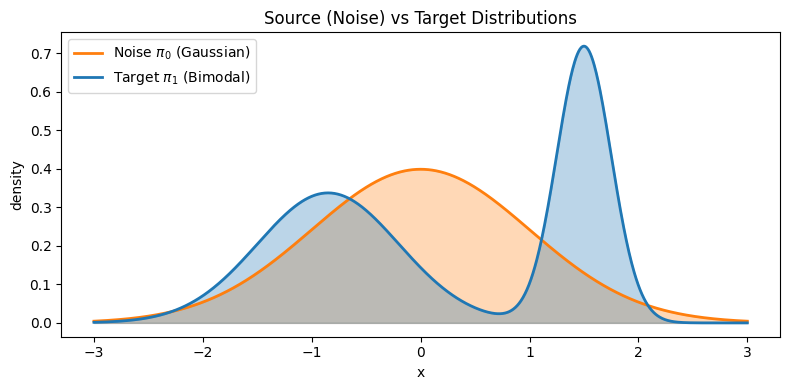

In [2]:
# Define 1D bimodal target distribution
mixture_prob = np.array([0.55, 0.45], dtype=float)
mixture_mus = np.array([-0.85, 1.5], dtype=float)
mixture_sigmas = np.array([0.65, 0.25], dtype=float)

# TODO: Implement these functions
# You only need to provide the function signatures for plotting code to work
def mixture_pdf(x: np.ndarray) -> np.ndarray:
    """Compute the PDF of a mixture of Gaussians.
    
    Args:
        x: Array of points at which to evaluate the PDF
        
    Returns:
        Array of PDF values at each point in x
    """
    # YOUR CODE HERE
    
    # defining the target bimodal distribution with means [-0.85, 1.5] and standard devations [0.65, 0.25]:
    
    X = []

    for val in x:
        
        # Hint: Use scipy.stats.norm.pdf to compute PDFs for each component,
        comp0 = scipy.stats.norm.pdf(val, loc = mixture_mus[0], scale = mixture_sigmas[0])
        comp1 = scipy.stats.norm.pdf(val, loc = mixture_mus[1], scale = mixture_sigmas[1])
        
        # then weight by mixture_prob and sum
        X.append((mixture_prob[0] * comp0) + (mixture_prob[1] * comp1))

    return np.array(X)


def mixture_sample(size: int) -> np.ndarray:
    """Sample from a mixture of Gaussians.
    
    Args:
        size: Number of samples to generate
        
    Returns:
        Array of samples from the mixture distribution
    """
    # YOUR CODE HERE
    # Hint: First choose which component to sample from (based on mixture_prob),
    # then sample from the corresponding Gaussian
    
    choose_comp = np.random.choice([0, 1], p=mixture_prob, size=size)
    count0 = np.count_nonzero(choose_comp == 0)
    count1 = np.count_nonzero(choose_comp == 1)
    samples0 = np.random.normal(mixture_mus[0], mixture_sigmas[0], count0)
    samples1 = np.random.normal(mixture_mus[1], mixture_sigmas[1], count1)
    samples = np.concatenate((samples0, samples1))
    np.random.shuffle(samples)
    return samples

# Visualize the distributions
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
x_all = np.linspace(-3, 3, 1000)
pdf_noise = scipy.stats.norm.pdf(x_all, loc=0, scale=1)
pdf_target = mixture_pdf(x=x_all)
ax.plot(x_all, pdf_noise, label="Noise $\pi_0$ (Gaussian)", color="tab:orange", linewidth=2)
ax.fill_between(x_all, pdf_noise, alpha=0.3, color="tab:orange")
ax.plot(x_all, pdf_target, label="Target $\pi_1$ (Bimodal)", color="tab:blue", linewidth=2)
ax.fill_between(x_all, pdf_target, alpha=0.3, color="tab:blue")
ax.legend()
ax.set_title("Source (Noise) vs Target Distributions")
ax.set_xlabel("x")
ax.set_ylabel("density")
plt.tight_layout()
plt.show()


### Understanding Straight-Line Reference Paths

For continuous flow matching, we use **straight-line reference paths**. Given a noise sample $x_0 \sim \pi_0$ and a target sample $x_1 \sim \pi_1$, we define the path:

$$x_t = (1-t) x_0 + t x_1$$

The velocity along this path is simply:

$$v(x_t, t) = x_1 - x_0$$

This is the target velocity that our model should learn to predict.


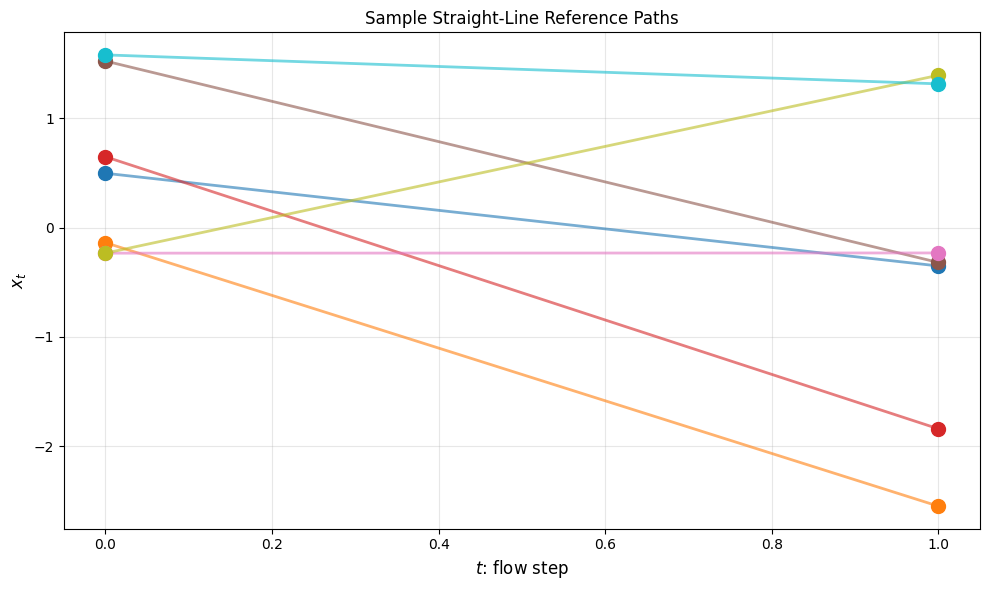

In [3]:
# Visualize straight-line reference paths
# TODO: Implement linear interpolation function
# You only need to provide the function signature for plotting code to work
def interpolate_linear(x_0, x_1, t):
    """Linear interpolation between x_0 and x_1 at time t.
    
    Args:
        x_0: Starting point (can be scalar or array)
        x_1: Ending point (can be scalar or array)
        t: Interpolation parameter in [0, 1] (can be scalar or array)
        
    Returns:
        Interpolated value(s)
    """
    # YOUR CODE HERE

    # t == amount of influence from the target data

    return (1 - t)*x_0 + t*x_1


# Sample some paths
n_samples = 7
x_0_samples = np.random.randn(n_samples)
x_1_samples = mixture_sample(size=n_samples)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
t = np.linspace(0, 1, 100)
colors = plt.cm.tab10(np.linspace(0, 1, n_samples))

for i in range(n_samples):
    path = interpolate_linear(x_0_samples[i], x_1_samples[i], t)

    ax.plot(t, path, alpha=0.6, color=colors[i], linewidth=2)
    ax.scatter([0, 1], [x_0_samples[i], x_1_samples[i]], 
               color=colors[i], s=100, zorder=5)

ax.set_xlabel("$t$: flow step", fontsize=12)
ax.set_ylabel("$x_t$", fontsize=12)
ax.set_title("Sample Straight-Line Reference Paths")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### Simple 1D Flow Matching Model

Now let's implement a simple neural network to learn the velocity field:

**TODO**: Implement the `FlowMatchingModel1D` class and the `train_1d_model` function below.


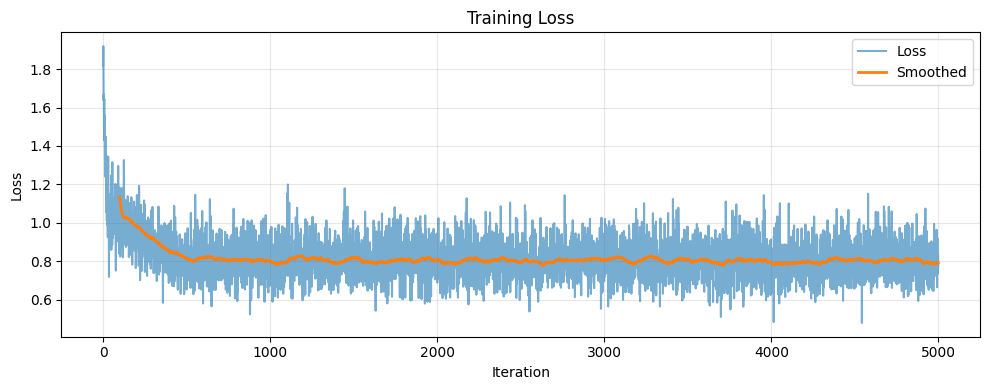

In [4]:
# TODO: Implement the MLP model for 1D continuous flow matching
# Architecture description:
# - Input: (t, x_t) where t is time and x_t is the position
# - Output: velocity v(x_t, t) (scalar)
# - Architecture: MLP with:
#   * Input layer: 2 dimensions (concatenated t and x_t)
#   * Hidden layers: You can choose the number of layers and hidden dimensions
#   * Output layer: 1 dimension (velocity)
#   * Activation functions: You can choose (e.g., ReLU, ELU, Swish, etc.)
class FlowMatchingModel1D(nn.Module):
    """Simple MLP for 1D flow matching."""
    def __init__(self, hidden_dim: int = 64):
        super().__init__()
        # YOUR CODE HERE
        # Define your MLP layers here
        # Example structure (you can modify):
        # - Linear(input_dim=2, hidden_dim)
        # - Activation
        # - Linear(hidden_dim, hidden_dim)
        # - Activation
        # - Linear(hidden_dim, 1)  # Output velocity
        self.model = nn.Sequential(
            nn.Linear(2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
    
    def forward(self, t: Tensor, x_t: Tensor) -> Tensor:
        """Predict velocity v(x_t, t).
        
        Args:
            t: Time tensor [batch_size, 1] or [batch_size]
            x_t: Position tensor [batch_size, 1]
            
        Returns:
            Velocity tensor [batch_size, 1]
        """
        # YOUR CODE HERE
        # 1. Ensure t and x_t have compatible shapes

        if t.dim() == 1:
            t = t.unsqueeze(1) # t -> [batch_size, 1]
        
        if x_t.dim() == 1:
            x_t = x_t.unsqueeze(1) # x_t -> [batch_size, 1]

        # 2. Concatenate t and x_t along the feature dimension
        inputs = torch.cat([t, x_t], dim=1)
        
        # 3. Pass through your MLP layers
        v = self.model(inputs)
        
        # 4. Return the velocity prediction
        return v


# TODO: Implement the training function
# Your function should:
# - Set up an optimizer (you can choose which one and the learning rate)
# - For each iteration:
#   1. Sample x_1 from target distribution, x_0 from noise
#   2. Sample random time t
#   3. Compute x_t using linear interpolation: x_t = (1-t)*x_0 + t*x_1
#   4. Compute target velocity: v_target = x_1 - x_0
#   5. Predict velocity using the model
#   6. Compute MSE loss and backpropagate
# - Return the list of losses
def train_1d_model(model, n_iterations=5000, batch_size=256, lr=1e-3):
    # YOUR CODE HERE
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    lossF = nn.MSELoss()
    losses = []

    for epoch in range(n_iterations):
        #   1. Sample x_1 from target distribution, x_0 from noise
        x_1 = torch.Tensor(mixture_sample(batch_size))

        # conditioning each x_0 to a specific mode of the target distribution 
        # since otherwise my generated points looked exactly like the original one
        x_0 = torch.empty(batch_size)
        for i in range(batch_size):
            if x_1[i] < 0:
                x_0[i] = torch.randn(1) * mixture_sigmas[0]
            else:
                x_0[i] = torch.randn(1) * mixture_sigmas[1]
        
        #   2. Sample random time t
        t = torch.rand(batch_size)
        
        #   3. Compute x_t using linear interpolation: x_t = (1-t)*x_0 + t*x_1
        x_t = interpolate_linear(x_0, x_1, t)
        
        #   4. Compute target velocity: 
        v_target = (x_1 - x_0).unsqueeze(1)
        
        #   5. Predict velocity using the model
        v_predict = model(t, x_t)
        
        #   6. Compute MSE loss and backpropagate
        loss = lossF(v_target, v_predict)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
        # - Return the list of losses
    return losses


# Train the model
model_1d = FlowMatchingModel1D(hidden_dim=64)
losses = train_1d_model(model_1d, n_iterations=5000)

# Plot training loss (this plotting code is provided - you just need to compute 'losses')
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(losses, alpha=0.6, label="Loss")
window = 100
smoothed = np.convolve(losses, np.ones(window)/window, mode='valid')
ax.plot(range(window-1, len(losses)), smoothed, label="Smoothed", linewidth=2)
ax.set_xlabel("Iteration")
ax.set_ylabel("Loss")
ax.set_title("Training Loss")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Sampling from the 1D Model

Now let's sample from the trained model by integrating the learned velocity field:


<>:51: SyntaxWarning: invalid escape sequence '\p'
<>:51: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_1948/4219690714.py:51: SyntaxWarning: invalid escape sequence '\p'
  ax.plot(x_all, mixture_pdf(x_all), label="Target $\pi_1$",


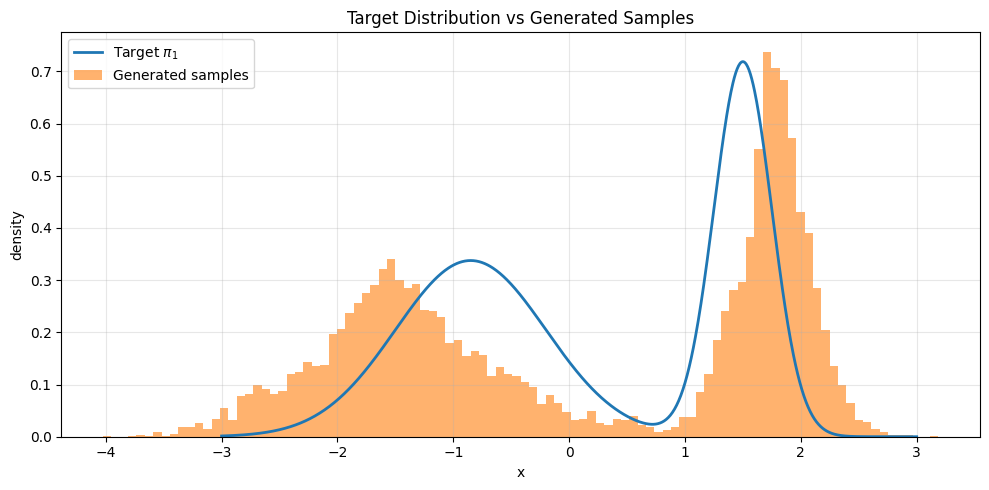

In [5]:
# TODO: Implement the sampling function for 1D flow matching
# Your function should:
# - Start from noise: x_0 ~ N(0, 1)
# - Use Euler integration to integrate the velocity field from t=0 to t=1
# - For each step:
#   1. Get current time t
#   2. Get velocity from model: v = model(t, x_t)
#   3. Update position: x_t = x_t + v * dt (Euler step)
# - Return the final samples as numpy array
@torch.no_grad()
def sample_1d(model, n_samples=10000, n_steps=50):
    """Sample from the 1D flow matching model using Euler integration.
    
    Args:
        model: Trained FlowMatchingModel1D
        n_samples: Number of samples to generate
        n_steps: Number of Euler integration steps
        
    Returns:
        numpy array of shape [n_samples, 1] containing generated samples
    """
    # YOUR CODE HERE
    # 1. Set model to eval mode
    model.eval()
    
    # 2. Initialize x_t from noise distribution (Gaussian)
    x_t = torch.randn(n_samples, 1)
    
    # 3. Create time points from 0 to 1
    t = np.linspace(0, 1, n_steps)

    dt = 1.0 / n_steps
    # 4. Loop through time steps:
    #    - Get current time t
    for curr in t:
        in_t = torch.full((n_samples, 1), curr)
        #    - Compute velocity 
        v = model(in_t, x_t)
        #    - Update: 
        x_t = x_t + v * dt

    # 5. Return samples as numpy array
    return x_t.numpy().flatten()

# Generate samples
samples = sample_1d(model_1d, n_samples=10000, n_steps=50)

# Visualize results
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
x_all = np.linspace(-3, 3, 1000)
ax.plot(x_all, mixture_pdf(x_all), label="Target $\pi_1$", 
        color="tab:blue", linewidth=2)
ax.hist(samples.flatten(), bins=100, density=True, alpha=0.6, 
        label="Generated samples", color="tab:orange")
ax.legend()
ax.set_xlabel("x")
ax.set_ylabel("density")
ax.set_title("Target Distribution vs Generated Samples")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### Section 1.2: 2D Continuous Flow Matching

Now let's move to a more practical 2D example. We'll work with a 2D checkerboard dataset and implement everything from scratch.


In [6]:
# Additional imports for 2D example
from matplotlib import cm
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='torch')


In [7]:
# 2D Checkerboard dataset generator
def inf_train_gen(batch_size: int = 200, device: str = "cpu"):
    """Generate 2D checkerboard pattern samples."""
    x1 = torch.rand(batch_size, device=device) * 4 - 2
    x2_ = torch.rand(batch_size, device=device) - torch.randint(high=2, size=(batch_size,), device=device) * 2
    x2 = x2_ + (torch.floor(x1) % 2)
    data = 1.0 * torch.cat([x1[:, None], x2[:, None]], dim=1) / 0.45
    return data.float()


### 2D Velocity Field Model

We'll use an MLP to predict the 2D velocity field:

**TODO**: Implement the `ContinuousFlowModel` class below. You have freedom in choosing the architecture (number of layers, hidden dimensions, activations).


In [12]:
# Activation function (provided)
class Swish(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x: Tensor) -> Tensor:
        return torch.sigmoid(x) * x

# TODO: Implement the 2D continuous flow matching model
# Architecture description:
# - Input: (x, t) where x is 2D position [batch, 2] and t is time [batch] or [batch, 1]
# - Output: 2D velocity vector v(x, t) [batch, 2]
# - Architecture: MLP with:
#   * Input layer: input_dim + time_dim dimensions (concatenated x and t)
#   * Hidden layers: You can choose the number of layers and hidden dimensions
#   * Output layer: input_dim dimensions (2D velocity vector)
#   * Activation functions: You can choose (e.g., ReLU, ELU, Swish, etc.)
# - Important: Handle reshaping appropriately - x might have different shapes
class ContinuousFlowModel(nn.Module):
    """MLP for 2D continuous flow matching."""
    def __init__(self, input_dim: int = 2, time_dim: int = 1, hidden_dim: int = 128):
        super().__init__()
        self.input_dim = input_dim
        self.time_dim = time_dim
        self.hidden_dim = hidden_dim
        
        # YOUR CODE HERE
        # Define your MLP layers here
        # Example structure (you can modify):
        # - Linear(input_dim + time_dim, hidden_dim)
        # - Activation
        # - Linear(hidden_dim, hidden_dim)
        # - Activation
        # - Linear(hidden_dim, input_dim)  # Output 2D velocity
        
        self.model = nn.Sequential(
            nn.Linear(input_dim + time_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )
    
    def forward(self, x: Tensor, t: Tensor) -> Tensor:
        """Predict 2D velocity v(x, t).
        
        Args:
            x: Position tensor [batch, 2] or other shapes
            t: Time tensor [batch] or [batch, 1]
            
        Returns:
            Velocity tensor with same shape as x
        """
        # YOUR CODE HERE
        # 1. Save original shape of x
        shape_x = x.shape
        
        # 2. Reshape x to (batch_size, input_dim)
        x = x.reshape(shape_x[0], self.input_dim)
        
        # 3. Ensure t has shape (batch_size, 1)
        if t.dim() == 1:
            t = t.unsqueeze(1) # t -> [batch_size, 1]

        # 4. Concatenate x and t along feature dimension
        inputs = torch.cat((x, t), dim = 1)
        
        # 5. Pass through your MLP layers
        v = self.model(inputs)
        
        # 6. Reshape output back to original shape of x
        v = v.reshape(shape_x)

        return v


### Training the 2D Model

We'll implement the training from scratch using simple linear interpolation paths:

**TODO**: Implement the training loop below. You need to:
1. Set up the optimizer
2. Implement the training step with linear interpolation paths
3. Compute the loss (MSE between predicted and target velocity)


In [13]:
# Training hyperparameters
lr = 0.001  # You can adjust this
batch_size = 4096
iterations = 20001
print_every = 2000
hidden_dim = 512  # You can adjust this

# Initialize model
vf = ContinuousFlowModel(input_dim=2, time_dim=1, hidden_dim=hidden_dim)

# TODO: Set up optimizer (you can choose optimizer type and learning rate)
# YOUR CODE HERE
optimizer = optim.Adam(vf.parameters(), lr = lr)
lossF = nn.MSELoss()
losses = []

# Training loop
start_time = time.time()
for i in range(iterations):
    # TODO: Implement the training step
    # 1. Zero gradients
    optimizer.zero_grad()
    
    # 2. Sample data: x_1 from checkerboard, x_0 from noise (provided below)
    x_1 = inf_train_gen(batch_size=batch_size, device=device)
    x_0 = torch.randn_like(x_1)
    
    # 3. Sample time t uniformly in [0, 1] (shape: [batch_size, 1])
    t = torch.rand(batch_size, 1)
    
    # 4. Compute linear interpolation: x_t = (1-t)*x_0 + t*x_1
    x_t = interpolate_linear(x_0, x_1, t)
    
    # 5. Compute target velocity: v_target = x_1 - x_0
    v_target = x_1 - x_0
    
    # 6. Predict velocity using your model: v_pred = vf(x_t, t.squeeze(-1))
    v_pred = vf(x_t, t.squeeze(-1))
    
    # 7. Compute MSE loss between v_pred and v_target
    loss = lossF(v_target, v_pred)
    
    # 8. Backpropagate and update weights
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    
    # Log progress (provided - you just need to compute 'loss')
    if (i+1) % print_every == 0:
        elapsed = time.time() - start_time
        print(f'| iter {i+1:6d} | {elapsed*1000/print_every:5.2f} ms/step | loss {loss.item():8.3f}')
        start_time = time.time()


| iter   2000 | 56.05 ms/step | loss    3.836
| iter   4000 | 56.77 ms/step | loss    3.784
| iter   6000 | 56.14 ms/step | loss    3.695
| iter   8000 | 54.04 ms/step | loss    3.731
| iter  10000 | 53.55 ms/step | loss    3.777
| iter  12000 | 53.31 ms/step | loss    3.729
| iter  14000 | 53.85 ms/step | loss    3.842
| iter  16000 | 57.98 ms/step | loss    3.754
| iter  18000 | 62.39 ms/step | loss    3.812
| iter  20000 | 55.91 ms/step | loss    3.683


### Sampling from the 2D Model

Now let's sample from the trained model using simple Euler integration:

**TODO**: Implement the Euler integration sampling function below.


In [18]:
# TODO: Implement Euler integration for sampling
@torch.no_grad()
def sample_2d_euler(model, x_init, n_steps=20, return_intermediates=True):
    """Sample from 2D flow matching model using Euler integration."""
    # YOUR CODE HERE

    model.eval()
    
    # Your function should:
    
    # - Start from x_init (noise)
    x_t = x_init
    n_samples = x_init.shape[0]

    t = np.linspace(0, 1, n_steps)
    dt = 1.0 / n_steps

    if return_intermediates:
        trajectory = [x_t.clone()]
        
    # - For n_steps iterations:
    for curr in t:
    #   1. Get current time t
        in_t = torch.full((n_samples, 1), curr)
        
    #   2. Get velocity from model: v = model(x_t, t)
        v = model(x_t, in_t)
        
    #   3. Update: x_t = x_t + v * dt (Euler step)
        x_t = x_t + v * dt
        
    # - Return intermediate states for visualization
        if return_intermediates:
            trajectory.append(x_t.clone())

    if return_intermediates:
        return torch.stack(trajectory, dim=0)
    else:
        return x_t
    

# Sample from the model
step_size = 0.05
n_steps = int(1.0 / step_size)
batch_size_sample = 50000
x_init = torch.randn((batch_size_sample, 2), dtype=torch.float32, device=device)

sol = sample_2d_euler(vf, x_init, n_steps=n_steps, return_intermediates=True)


### Visualize the Sampling Process

Let's visualize how samples evolve from noise to the checkerboard pattern:


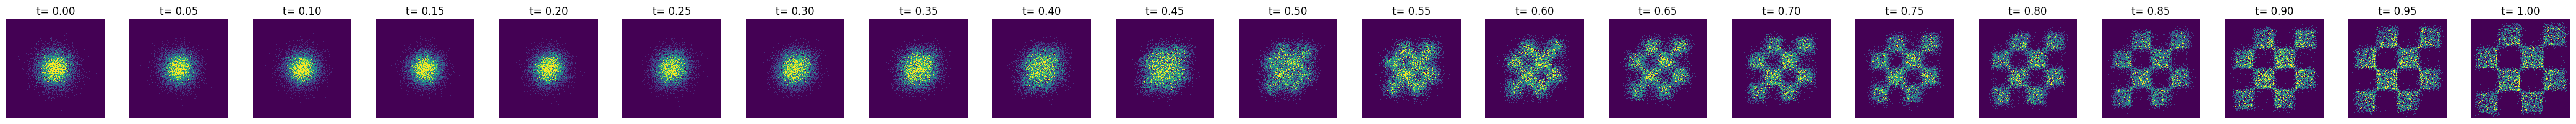

In [21]:
# Visualize the path (plotting code provided - you just need to compute 'sol')
T_np = np.linspace(0, 1, len(sol))

fig, axs = plt.subplots(1, len(sol), figsize=(2*len(sol), 2))

for i in range(len(sol)):
    H = axs[i].hist2d(sol[i, :, 0], sol[i, :, 1], 300, range=((-5, 5), (-5, 5)))
    
    cmin = 0.0
    cmax = np.quantile(H[0], 0.99)
    norm = cm.colors.Normalize(vmax=cmax, vmin=cmin)
    
    _ = axs[i].hist2d(sol[i, :, 0], sol[i, :, 1], 300, 
                      range=((-5, 5), (-5, 5)), norm=norm)
    
    axs[i].set_aspect('equal')
    axs[i].axis('off')
    axs[i].set_title(f't= {T_np[i]:.2f}')
    
plt.tight_layout()
plt.show()


## Part 2: Discrete Flow Matching

Discrete flow matching extends the concept to discrete data (e.g., text tokens, categorical variables). Instead of predicting a continuous velocity field, the model predicts probability distributions over discrete states.


### Section 2.1: Discrete vs Continuous Flow Matching

**Key Differences:**

1. **State Space**: 
   - Continuous: Real-valued vectors $x \in \mathbb{R}^d$
   - Discrete: Categorical variables $x \in \{0, 1, \ldots, V-1\}^d$ (vocabulary size $V$)

2. **Model Output**:
   - Continuous: Velocity vector $v(x_t, t) \in \mathbb{R}^d$
   - Discrete: Probability distribution $p(x_1 | x_t, t) \in \Delta^V$ (simplex)

3. **Training Objective**:
   - Continuous: $L_2$ loss on velocity prediction
   - Discrete: Cross-entropy or generalized KL divergence

4. **Sampling**:
   - Continuous: ODE integration (Euler, Runge-Kutta, etc.)
   - Discrete: Discrete-time Markov chain with probability transitions

**When to use Discrete FM:**
- Text generation (tokens)
- Categorical data
- Any problem with discrete state spaces


### Section 2.2: 2D Discrete Flow Matching Implementation

Let's implement discrete flow matching on a 2D discrete checkerboard dataset.


In [22]:
# No additional imports needed - we'll implement discrete flow matching from scratch


In [28]:
# Simple discrete dataset: convert 2D moons dataset to discrete tokens
# This is simpler than checkerboard and easier to visualize
def generate_discrete_moons(batch_size: int = 256, vocab_size: int = 128, device: str = "cpu"):
    """Generate discrete 2D data by quantizing the moons dataset."""
    from sklearn.datasets import make_moons
    x_1_continuous, _ = make_moons(batch_size, noise=0.05)
    x_1_continuous = torch.from_numpy(x_1_continuous).float()
    
    # Normalize and quantize to [0, vocab_size-1]
    x_1_continuous = (x_1_continuous - x_1_continuous.min()) / (x_1_continuous.max() - x_1_continuous.min())
    x_1_continuous = x_1_continuous * (vocab_size - 1)
    x_1 = torch.round(torch.clamp(x_1_continuous, min=0.0, max=vocab_size - 1)).long()
    
    return x_1


### Discrete Flow Matching Model

The model predicts probability distributions over the vocabulary for each position:

**TODO**: Implement the `DiscreteFlowModel` class below. This model should output logits over the vocabulary.


In [65]:
# TODO: Implement the discrete flow matching model
# Architecture description:
# - Input: discrete tokens x_t [batch, dim] and time t [batch]
# - Output: logits over vocabulary for each dimension [batch, dim, vocab_size]
# - Architecture:
#   * Token embedding: nn.Embedding(vocab_size, hidden_dim) to embed discrete tokens
#   * MLP that takes [time, embedded_tokens_flattened] and outputs logits
#     - Input size: dim * hidden_dim + 1 (for time)
#     - Hidden layers: You can choose the number of layers and hidden dimensions
#     - Output size: dim * vocab_size
#   * Reshape output to [batch, dim, vocab_size]
class DiscreteFlowModel(nn.Module):
    """MLP for discrete flow matching (probability denoiser)."""
    def __init__(self, dim: int = 2, hidden_dim: int = 128, vocab_size: int = 128):
        super().__init__()
        self.vocab_size = vocab_size
        self.dim = dim
        self.hidden_dim = hidden_dim
        
        # YOUR CODE HERE
        # Define your model components:
        # 1. Token embedding layer: nn.Embedding(vocab_size, hidden_dim)
        self.embed = nn.Embedding(vocab_size, hidden_dim)

        self.MLP = nn.Sequential(
        # 2. MLP layers:
        #    - Input: dim * hidden_dim + 1 (time + flattened embeddings)
            nn.Linear(self.dim * self.hidden_dim + 1, self.hidden_dim),
            nn.ReLU(),
        #    - Hidden layers: You can choose architecture
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.ReLU(),
        #    - Output: dim * vocab_size
            nn.Linear(self.hidden_dim, self.dim * self.vocab_size),
            nn.Tanh()
        )

    def forward(self, x_t: Tensor, t: Tensor) -> Tensor:
        """Predict logits over vocabulary for each dimension.
        
        Args:
            x_t: Discrete tokens [batch, dim]
            t: Time [batch]
            
        Returns:
            Logits [batch, dim, vocab_size]
        """
        # YOUR CODE HERE
        batch = x_t.shape[0]
        
        # 1. Embed tokens: x_emb = embed(x_t)  # [batch, dim, hidden_dim]
        x_emb = self.embed(x_t)
        
        # 2. Flatten embeddings: x_flat = x_emb.flatten(1, 2)  # [batch, dim * hidden_dim]
        embedded_tokens_flattened = x_emb.flatten(1, 2)
        
        # 3. Concatenate with time: h = cat([t.unsqueeze(-1), x_flat], dim=1)
        h = torch.cat([t.unsqueeze(-1), embedded_tokens_flattened], dim=1)
        
        # 4. Pass through MLP: logits_flat = net(h)  # [batch, dim * vocab_size]
        logits_flat = self.MLP(h)
        
        # 5. Reshape: logits = logits_flat.reshape(batch, dim, vocab_size)
        logits = logits_flat.reshape(batch, self.dim, self.vocab_size)

        return logits


### Training the Discrete Model

We'll use a simple approach: sample x_t by randomly choosing between x_0 and x_1 based on time t, then use cross-entropy loss:

**TODO**: Implement the training loop for discrete flow matching. You need to:
1. Set up the optimizer
2. Implement the training step with simple discrete path sampling
3. Compute cross-entropy loss


In [50]:
# Training hyperparameters
lr = 0.001  # You can adjust this
batch_size = 4096
iterations = 10001
print_every = 2000

vocab_size = 128
hidden_dim = 128  # You can adjust this

# Initialize model
model = DiscreteFlowModel(dim=2, hidden_dim=hidden_dim, vocab_size=vocab_size)

# TODO: Set up optimizer
# YOUR CODE HERE
optimizer = optim.Adam(model.parameters(), lr = lr)
lossF = nn.CrossEntropyLoss()

# Training loop
start_time = time.time()
for i in range(iterations):
    # TODO: Implement the training step
    # YOUR CODE HERE
    # Hint: 
    # - For discrete path: x_t = where(rand < t, x_1, x_0)
    # - Loss: cross_entropy(logits.flatten(0,1), x_1.flatten())
    
    # 1. Zero gradients
    optimizer.zero_grad()
    
    # 2. Sample target data x_1 (discrete moons) - use generate_discrete_moons()
    x_1 = generate_discrete_moons(batch_size, vocab_size)
    
    # 3. Sample source data x_0 uniformly from vocabulary [0, vocab_size-1]
    x_0 = torch.randint(low = 0, high= vocab_size, size = (batch_size, 2))
    
    # 4. Sample time t uniformly in [0, 1]
    t = torch.rand(batch_size)
    
    # 5. Sample x_t: for each position, choose x_1 with probability t, x_0 with probability (1-t)
    #    Hint: use torch.where(random_mask < t.unsqueeze(-1), x_1, x_0)
    random_mask = torch.rand_like(x_1.float())
    x_t = torch.where(random_mask < t.unsqueeze(-1), x_1, x_0)
    
    # 6. Get logits from model: logits = model(x_t, t)  # [batch, dim, vocab_size]
    logits = model(x_t, t)
    
    # 7. Compute cross-entropy loss: flatten logits and x_1, then use nn.functional.cross_entropy
    loss = lossF(logits.flatten(0, 1), x_1.flatten())
    
    # 8. Backpropagate and update weights
    loss.backward()
    optimizer.step()
    
    # Log progress (provided - you just need to compute 'loss')
    if (i+1) % print_every == 0:
        elapsed = time.time() - start_time
        print(f'| iter {i+1:6d} | {elapsed*1000/print_every:5.2f} ms/step | loss {loss.item():8.3f}')
        start_time = time.time()


| iter   2000 | 19.90 ms/step | loss    3.782
| iter   4000 | 19.39 ms/step | loss    3.757
| iter   6000 | 20.06 ms/step | loss    3.774
| iter   8000 | 19.33 ms/step | loss    3.770
| iter  10000 | 18.56 ms/step | loss    3.770


### Sampling from the Discrete Model

Sampling uses a simple discrete-time update rule:

**TODO**: Implement the discrete sampling function below.


In [85]:
# TODO: Implement discrete sampling function

@torch.no_grad()
def sample_discrete(model, n_samples=200, vocab_size=128, n_steps=20, return_intermediates=True):
    """Sample from discrete flow matching model."""
    # YOUR CODE HERE

    model.eval()
    
    # Your function should:
    # - Start from random discrete tokens x_t
    x_t = torch.randint(low=0, high=vocab_size, size=(n_samples, model.dim))

    n_samples = x_t.shape[0]

    t = torch.Tensor(np.linspace(0, 1 - 1e-5, n_steps))
    dt = 1.0 / n_steps

    if return_intermediates:
        trajectory = [(x_t.clone(), 0.0)]

    # - For each step until t=1:
    for curr in t:
        in_t = torch.full((n_samples,), curr)
        
    #   1. Get logits from model and convert to probabilities: p1 = softmax(logits)
        logits = model(x_t, in_t)
        p1 = torch.softmax(logits, dim = -1)
        
    #   2. Compute update: u = (p1 - one_hot(x_t)) / (1 - t)
        u = (p1 - nn.functional.one_hot(x_t, num_classes=vocab_size).float()) / (1 - curr)
        
    #   3. Update probabilities: probs = one_hot(x_t) + h * u (clamp and renormalize)
        probs = nn.functional.one_hot(x_t, num_classes=vocab_size).float() + dt * u
        probs = probs.clamp(min=1e-6)     # clamp
        probs = probs / probs.sum(dim=-1, keepdim=True)    # renormalize
        
    #   4. Sample new x_t from updated distribution
        x_t = torch.multinomial(probs.view(-1, vocab_size), num_samples=1).view(n_samples, x_t.shape[1])

    # - Return intermediate states for visualization
        if return_intermediates:
            trajectory.append((x_t.clone(), float(curr)))

    if return_intermediates:
        return trajectory
    else:
        return x_t
        
    
# Sample from the model
n_samples = 200
n_steps = 20
results = sample_discrete(model, n_samples=n_samples, vocab_size=vocab_size, 
                         n_steps=n_steps, return_intermediates=True)


### Visualize Discrete Sampling

Let's visualize how discrete samples evolve (note: discrete data is quantized, so visualization shows the discrete grid):


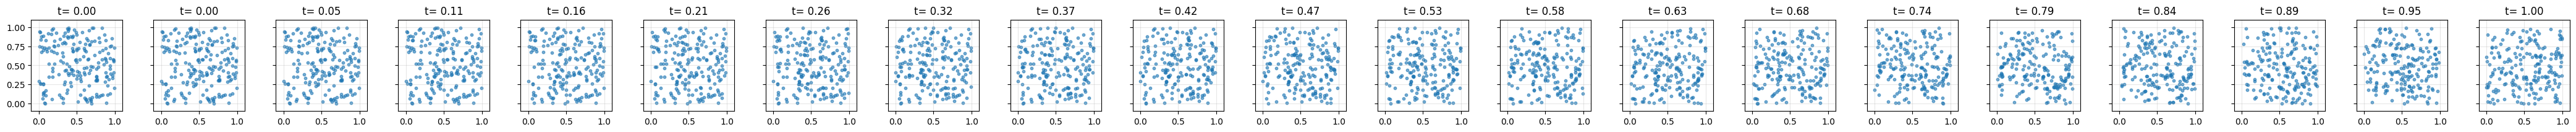

In [86]:
# Visualize discrete sampling (plotting code provided - you just need to compute 'results')
fig, axs = plt.subplots(1, len(results), figsize=(2*len(results), 2), sharex=True, sharey=True)

for idx, (x_t, t_val) in enumerate(results):
    x_t_np = x_t.numpy()
    
    # Convert discrete tokens back to continuous space for visualization
    # (just for plotting - the actual data is discrete)
    x_continuous = x_t_np.astype(float) / vocab_size
    
    axs[idx].scatter(x_continuous[:, 0], x_continuous[:, 1], s=10, alpha=0.6)
    axs[idx].set_title(f't= {t_val:.2f}')
    axs[idx].set_xlim(-0.1, 1.1)
    axs[idx].set_ylim(-0.1, 1.1)
    axs[idx].set_aspect('equal')
    axs[idx].grid(True, alpha=0.3)
    
plt.tight_layout()
plt.show()


## Conclusion

### Summary

In this practical session, we've covered:

1. **Continuous Flow Matching**:
   - Learned velocity fields for continuous data
   - Used straight-line reference paths
   - Trained on 1D and 2D examples
   - Sampled using ODE integration

2. **Discrete Flow Matching**:
   - Learned probability distributions for discrete data
   - Used discrete probability paths
   - Trained on 2D discrete checkerboard
   - Sampled using discrete-time Markov chains

### Key Takeaways

- Flow matching provides a flexible framework for generative modeling
- The velocity field (continuous) or probability denoiser (discrete) learns to transport samples
- Training is straightforward: minimize prediction error on reference paths
- Sampling requires integration (ODE for continuous, Markov chain for discrete)

### Further Reading

- [Flow Matching for Generative Modeling](https://arxiv.org/abs/2210.02747) - Original continuous FM paper
- [Discrete Flow Matching](https://arxiv.org/abs/2407.15595) - Discrete FM paper
- [Flow Matching Guide and Code](https://arxiv.org/abs/2412.06264) - Comprehensive guide
- [Facebook's Flow Matching Library](https://github.com/facebookresearch/flow_matching) - Implementation library
